# SAPEQ ROMS, TIW-MOC and heat budget, rough analysis

Analysis of the SAPEQ ABLM control simulation from the paper:

Holmes R. M., S. McGregor, A. Santoso and M.H. England (2019) Contribution of Tropical Instability Waves to ENSO Irregularity, Climate Dynamics, 52, 1837-1855
https://link.springer.com/article/10.1007%2Fs00382-018-4217-0

To look at the TIW-driven Meridional Overturning Circulation (MOC) in depth and temperature coordinates, and the role of TIWs in the heat budget.

In [1]:
#Load required packages
%matplotlib inline
import matplotlib.pyplot as plt
import xarray as xr
from xgcm import Grid
import numpy as np
import pandas as pd
import cftime

import IPython.display
import cmocean as cm
import cartopy.crs as ccrs
import cartopy.feature as cft
import sys, os
import warnings
warnings.simplefilter("ignore")
from dask.distributed import Client

from xhistogram.xarray import histogram

In [2]:
client = Client(n_workers=16)
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/8787/status,
Dashboard: /proxy/8787/status,Workers: 16
Total threads: 16,Total memory: 44.92 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:37479,Workers: 16
Dashboard: /proxy/8787/status,Total threads: 16
Started: Just now,Total memory: 44.92 GiB
Comm: tcp://127.0.0.1:38113,Total threads: 1
Dashboard: /proxy/43125/status,Memory: 2.81 GiB
Nanny: tcp://127.0.0.1:40897,


## Load data files and add some extra information (e.g. binning)

In [3]:
# files:
base = '/g/data/e14/rmh561/ROMS/SAPEQ/OUT/';
favg = xr.open_dataset(base + 'ocean_avg_ABLMe.nc').chunk({'ocean_time': 1})
favg_mean = xr.open_dataset(base + 'ocean_avg_ABLMe.ncra.nc').chunk({'ocean_time': 1})
fhis = xr.open_dataset(base + 'ocean_his_ABLMe.nc').chunk({'ocean_time': 1})
fdia = xr.open_dataset(base + 'ocean_dia_ABLMe.nc').chunk({'ocean_time': 1})
fdia_mean = xr.open_dataset(base + 'ocean_dia_ABLMe.ncra.nc').chunk({'ocean_time': 1})

# Add z_rho/z_w as coordinate:
favg_mean.coords["z_rho"] = favg_mean.z_rho.fillna(0.)
favg_mean.coords["z_w"] = favg_mean.z_w.fillna(0.)
favg.coords["z_rho"] = favg.z_rho.fillna(0.)
favg.coords["z_w"] = favg.z_w.fillna(0.)
fdia.coords["z_rho"] = favg.z_rho.fillna(0.)
fdia.coords["z_w"] = favg.z_w.fillna(0.)
fdia_mean.coords["z_rho"] = favg_mean.z_rho.fillna(0.)
fdia_mean.coords["z_w"] = favg_mean.z_w.fillna(0.)

In [4]:
# Define z and T axes for rebinning:
zvec = np.concatenate((-5000.,favg_mean.z_rho.min('xi_rho').min('eta_rho').isel(ocean_time=0).values,2.),axis=None)
dT = 0.5
tvec = np.arange(-2.,34.,dT)

def add_zT(f):
    f = f.assign_coords({'z_e':zvec}).assign_coords({'z':zvec[1:]})
    f = f.assign_coords({'T_e':tvec}).assign_coords({'T':tvec[1:]})
    return(f)

favg_mean = add_zT(favg_mean)
favg = add_zT(favg)
fdia_mean = add_zT(fdia_mean)
fdia = add_zT(fdia)

Cp = 3985.0
rho0 = favg.rho0

# Generate xgcm grid object:
grid = Grid(favg_mean,coords={"xi":{"center":"xi_rho","inner":"xi_u"},"eta":{"center":"eta_rho","inner":"eta_v"},"s":{"center":"s_rho","outer":"s_w"},"z":{"outer":"z_e","right":"z"},"T":{"outer":"T_e","right":"T"}},periodic=False)

In [ ]:
ln1,ln2 = -180.,-100.
lt1,lt2 = -6.,8.

ln1i,ln2i = int(abs(favg.lon_rho.isel(eta_rho=0)-ln1).argmin()),int(abs(favg.lon_rho.isel(eta_rho=0)-ln2).argmin())
lt1i,lt2i = int(abs(favg.lat_rho.isel(xi_rho=0)-lt1).argmin()),int(abs(favg.lat_rho.isel(xi_rho=0)-lt2).argmin())

t1,t2 = 100,200

# Limit time and space range for testing:
favg = favg.isel(xi_rho=slice(ln1i,ln2i)).isel(eta_rho=slice(lt1i,lt2i)).isel(ocean_time=slice(t1,t2))
fdia = fdia.isel(xi_rho=slice(ln1i,ln2i)).isel(eta_rho=slice(lt1i,lt2i)).isel(ocean_time=slice(t1,t2))

In [19]:
# CROCO run:
CROCOavg = xr.open_dataset('/g/data/e14/rmh561/croco/archive/ETPcroco/Run002/croco_avg.nc')
ln1ic,ln2ic = int(abs(CROCOavg.lon_rho.isel(eta_rho=0)-ln1).argmin()),int(abs(CROCOavg.lon_rho.isel(eta_rho=0)-ln2).argmin())
lt1ic,lt2ic = int(abs(CROCOavg.lat_rho.isel(xi_rho=0)-lt1).argmin()),int(abs(CROCOavg.lat_rho.isel(xi_rho=0)-lt2).argmin())
CROCOavg = CROCOavg.isel(xi_rho=slice(ln1ic,ln2ic)).isel(eta_rho=slice(lt1ic,lt2ic))

## Define some functions to calculate (differed) diffusive heat fluxes, air-sea heat fluxes and MOCs:

In [5]:
# Air-sea heat fluxes and mixing:

# Function to calculate (differed) 3D total vertical diffusive heat flux and air-sea component Eulerian:
def VertDiffHeatFluxE(favg,fdia):
    dz = favg.z_w.diff('s_w').rename({'s_w':'s_rho'}).assign_coords(s_rho=favg.s_rho)
    Fz = (Cp*rho0*fdia.temp_vdiff*dz).cumsum('s_rho')
    Fz = xr.concat([0*Fz.isel(s_rho=0),Fz],dim='s_rho').rename({'s_rho':'s_w'}).assign_coords(s_w=favg.s_w)
    fdia['Fz'] = Fz

    # Calculate component due to surface fluxes/shortwave penetration (follow code in lmd_skpp.F, lmd_swfrac.F):
    #lmd_Jwt = 1, lmd_mu1 = 0.35, lmd_mu2 = 23.0, lmd_r1 = 0.58
    fac1 = -1.0/0.35
    fac2 = -1.0/23.0
    fac3 = 0.58
    d = favg.z_w.where(favg.s_w==0.,other=0.)-favg.z_w # Depth on z_w
    Fz_shf = favg.swrad*(np.exp(d*fac1)*fac3+np.exp(d*fac2)*(1.0-fac3)) # Shortwave flux

    # Add surface flux component:
    surf = xr.zeros_like(favg.s_w)
    surf[-1] = 1.
    Fz_shf += (favg.shflux-favg.swrad)*surf # Total surface flux (3D)
    fdia['Fz_shf'] = Fz_shf
    
    return(fdia)

# Function to calculate Lagrangian fluxes integrated in x:
def VertDiffHeatFunction(favg,fdia):

    dz = favg.z_w.diff('s_w').rename({'s_w':'s_rho'}).assign_coords(s_rho=favg.s_rho)
    
    # Total component:
    Fz_conv = Cp*rho0*fdia.temp_vdiff*dz/favg.pm/favg.pn # J kg-1 degC-1 kg m-3 degC s-1 m3 = W
    HfDia = histogram(favg.temp.fillna(0.),bins=tvec,weights=Fz_conv.fillna(0.),dim=['xi_rho','s_rho'])
    HfDia = HfDia.cumsum('temp_bin').rename({'temp_bin':'T'})
    HfDia['T'] = tvec[1:]
    HfDia.coords['lat'] = fdia.lat_rho.mean('xi_rho')
    fdia['HfDia'] = HfDia
    
    # Air-sea heat flux component:
    Fz_conv_shf = (fdia.Fz_shf.diff('s_w').rename({'s_w':'s_rho'}).assign_coords(s_rho=favg.s_rho))/favg.pm/favg.pn
    HfDia_shf = histogram(favg.temp.fillna(0.),bins=tvec,weights=Fz_conv_shf.fillna(0.),dim=['xi_rho','s_rho'])
    HfDia_shf = HfDia_shf.cumsum('temp_bin').rename({'temp_bin':'T'})
    HfDia_shf['T'] = tvec[1:]
    HfDia_shf.coords['lat'] = fdia.lat_rho.mean('xi_rho')
    fdia['HfDia_shf'] = HfDia_shf

    return(fdia)

In [5]:
# Air-sea heat fluxes and mixing (based on new separated diagnostics):

# Function to calculate (differed) 3D vertical diffusive heat flux Eulerian from a convergence term:
def VertDiffHeatFluxE(favg,temp_vdiff):
    dz = favg.z_w.diff('s_w').rename({'s_w':'s_rho'}).assign_coords(s_rho=favg.s_rho)
    Fz = (Cp*rho0*temp_vdiff*dz).cumsum('s_rho')
    Fz = xr.concat([0*Fz.isel(s_rho=0),Fz],dim='s_rho').rename({'s_rho':'s_w'}).assign_coords(s_w=favg.s_w)
    return(Fz)

# Function to calculate Lagrangian flux integrated in x:
def VertDiffHeatFunction(favg,temp_vdiff):
    dz = favg.z_w.diff('s_w').rename({'s_w':'s_rho'}).assign_coords(s_rho=favg.s_rho)
    Fz_conv = Cp*rho0*temp_vdiff*dz/favg.pm/favg.pn # J kg-1 degC-1 kg m-3 degC s-1 m3 = W
    HfDia = histogram(favg.temp.fillna(0.),bins=tvec,weights=Fz_conv.fillna(0.),dim=['xi_rho','s_rho'])
    HfDia = HfDia.cumsum('temp_bin').rename({'temp_bin':'T'})
    HfDia['T'] = tvec[1:]
    HfDia.coords['lat'] = fdia.lat_rho.mean('xi_rho')
    return(HfDia)

In [6]:
# Function to calculate zonally-integrated Eulerian and Lagrangian MOCs (time mean, using xhistogram):
# This is done using xhistogram for xarray, see https://xhistogram.readthedocs.io/en/latest/tutorial.html
# Also see Jan's true zonal mean method in the COSIMA recipes https://github.com/COSIMA/cosima-recipes/blob/master/DocumentedExamples/True_Zonal_Mean.ipynb

# Eulerian MOC:
def CalcPsiE(favg):
    
    # Using pre-calculated z_v:
    # z_v = favg_mean.z_v.fillna(0.)
    # Using on-the-fly xgcm interp:
    z_v = grid.interp(favg.z_rho,axis='eta').rename({'xi_rho':'xi_v'}).rename('z_v')

    PsiE = histogram(z_v,bins=zvec,weights=favg.Hvom.fillna(0.),dim=['xi_v','s_rho'])
    PsiE = PsiE.cumsum('z_v_bin').rename({'z_v_bin':'z'})
    PsiE['z'] = zvec[1:]
    PsiE.coords['lat'] = favg.lat_v.mean('xi_v')
    favg['PsiEul'] = PsiE
    
    return(favg)

# Lagrangian T-space MOC:
def CalcPsiL(favg):

    temp_v = grid.interp(favg.temp,axis='eta').rename({'xi_rho':'xi_v'}).rename('temp_v')
    PsiL = histogram(temp_v.fillna(0.),bins=tvec,weights=favg.Hvom.fillna(0.),dim=['xi_v','s_rho'])
    PsiL = PsiL.cumsum('temp_v_bin').rename({'temp_v_bin':'T'})
    PsiL['T'] = tvec[1:]
    PsiL.coords['lat'] = favg.lat_v.mean('xi_v')
    favg['PsiLag'] = PsiL
    
    return(favg)

In [7]:
# Do the (differed) calculations for mean and time-variable components:
favg_mean = CalcPsiL(favg_mean)
favg = CalcPsiL(favg)
favg_mean = CalcPsiE(favg_mean)
favg = CalcPsiE(favg)

fdia_mean['Fz'] = VertDiffHeatFluxE(favg_mean,fdia_mean.temp_vdiff)
fdia_mean['Fz_dif'] = VertDiffHeatFluxE(favg_mean,fdia_mean.temp_vdiffDIF)
fdia_mean['Fz_shf'] = VertDiffHeatFluxE(favg_mean,fdia_mean.temp_vdiffSHF+fdia_mean.temp_vdiffNOL)
fdia['Fz'] = VertDiffHeatFluxE(favg,fdia.temp_vdiff)
fdia['Fz_dif'] = VertDiffHeatFluxE(favg,fdia.temp_vdiffDIF)
fdia['Fz_shf'] = VertDiffHeatFluxE(favg,fdia.temp_vdiffSHF+fdia.temp_vdiffNOL)

fdia_mean['HfDia'] = VertDiffHeatFunction(favg_mean,fdia_mean.temp_vdiff)
fdia_mean['HfDia_dif'] = VertDiffHeatFunction(favg_mean,fdia_mean.temp_vdiffDIF)
fdia_mean['HfDia_shf'] = VertDiffHeatFunction(favg_mean,fdia_mean.temp_vdiffSHF+fdia_mean.temp_vdiffNOL)
fdia['HfDia'] = VertDiffHeatFunction(favg,fdia.temp_vdiff)
fdia['HfDia_dif'] = VertDiffHeatFunction(favg,fdia.temp_vdiffDIF)
fdia['HfDia_shf'] = VertDiffHeatFunction(favg,fdia.temp_vdiffSHF + fdia.temp_vdiffNOL)

# fdia_mean['Fz_nol'] = VertDiffHeatFluxE(favg_mean,fdia_mean.temp_vdiffNOL)
# fdia['Fz_nol'] = VertDiffHeatFluxE(favg,fdia.temp_vdiffNOL)
# fdia['HfDia_nol'] = VertDiffHeatFunction(favg,fdia.temp_vdiffNOL)
# fdia_mean['HfDia_nol'] = VertDiffHeatFunction(favg_mean,fdia_mean.temp_vdiffNOL)

# fdia_mean = VertDiffHeatFluxE(favg_mean,fdia_mean)
# fdia = VertDiffHeatFluxE(favg,fdia)
# fdia_mean = VertDiffHeatFunction(favg_mean,fdia_mean)
# fdia = VertDiffHeatFunction(favg,fdia)

In [8]:
# Load calculations for a short 60-day period (should be representative):
favg = favg.isel(ocean_time=slice(0,60))
fdia = fdia.isel(ocean_time=slice(0,60))

In [9]:
favg_mean.PsiEul.load();
favg_mean.PsiLag.load();
favg.PsiEul.load();
favg.PsiLag.load();

In [10]:
# fdia_mean.Fz.load();
fdia_mean.Fz_shf.load();
fdia_mean.Fz_dif.load();
# fdia_mean.Fz_nol.load();
# fdia_mean.HfDia.load();
fdia_mean.HfDia_shf.load();
fdia_mean.HfDia_dif.load();
# fdia_mean.HfDia_nol.load();

In [11]:
# fdia.Fz.load();
fdia.Fz_shf.load();

distributed.worker - WARNING - Worker is at 82% memory usage. Pausing worker.  Process memory: 2.33 GiB -- Worker memory limit: 2.81 GiB
distributed.worker - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker.html#memtrim for more information. -- Unmanaged memory: 1.85 GiB -- Worker memory limit: 2.81 GiB
distributed.worker - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker.html#memtrim for more information. -- Unmanaged memory: 2.28 GiB -- Worker memory limit: 2.81 GiB
distributed.worker - WARNING - Worker is at 77% memory usage. Resuming worker. Process memory: 2.16 GiB -- Worker memory limit: 2.81 GiB
distributed.worker - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://dist

In [12]:
fdia.Fz_dif.load();
# fdia.Fz_nol.load();

In [13]:
# fdia.HfDia.load();
fdia.HfDia_shf.load();

In [14]:
fdia.HfDia_dif.load();
# fdia.HfDia_nol.load();

## Air-sea heat flux and maximum diffusive flux spatial plots

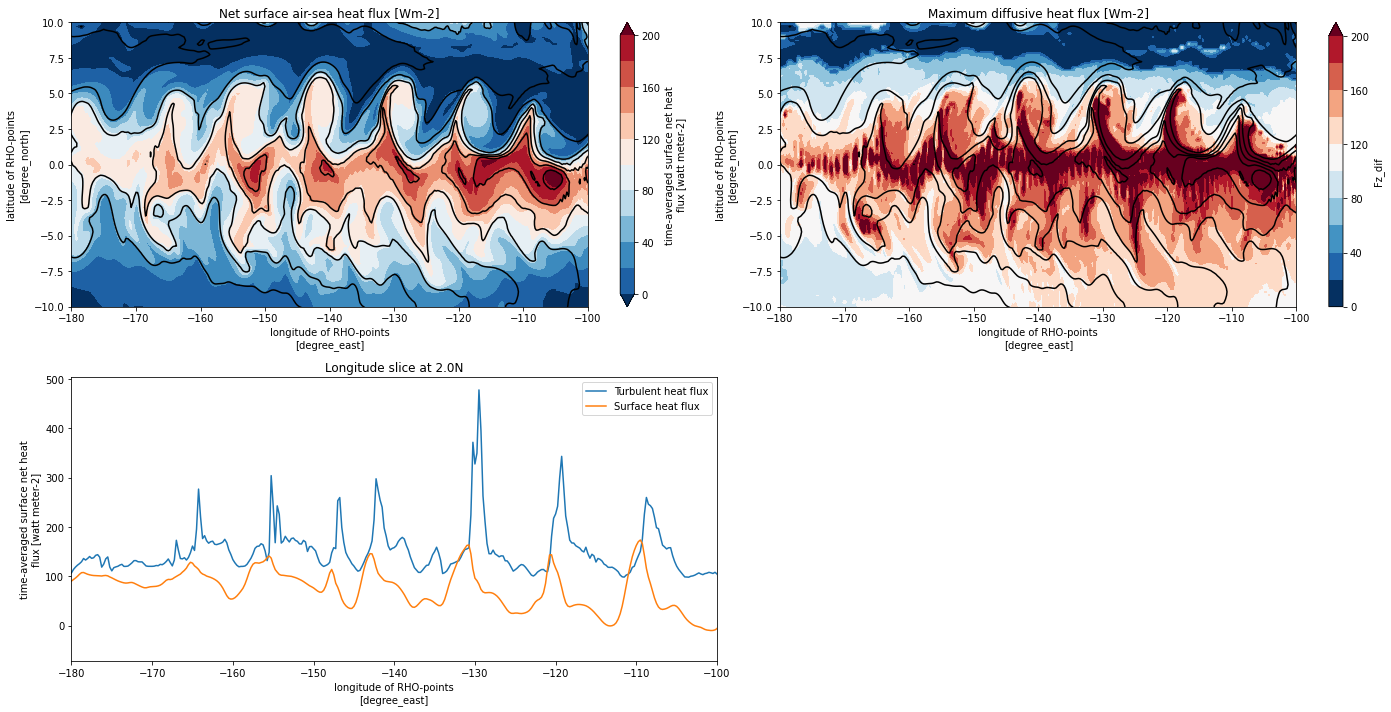

In [18]:
# Plot net air-sea heat flux and maximum diffusive flux:
time = 10
shflux = favg.shflux.isel(ocean_time=time)
Fz_diff_max = fdia.Fz_dif.isel(ocean_time=time).max('s_w') # -fdia.Fz_shf.isel(ocean_time=time)).max('s_w')
SST = favg.temp.isel(ocean_time=time).isel(s_rho=-1)

plt.figure(figsize=(20,10))
xlims = [-180.,-100.]
ylims = [-10.,10.]

lt = 2.0
ln = -130.
lt_ind = int(abs(favg.lat_rho.isel(xi_rho=0)-lt).argmin())
ln_ind = int(abs(favg.lon_rho.isel(eta_rho=0)-ln).argmin())

plt.subplot(2,2,1)
shflux.plot.contourf(x='lon_rho',y='lat_rho',levels=np.arange(0.,220.,20.),cmap='RdBu_r')
SST.plot.contour(x='lon_rho',y='lat_rho',levels=np.arange(0.,34.,1.),colors='k')
plt.xlim(xlims)
plt.ylim(ylims)
plt.title('Net surface air-sea heat flux [Wm-2]')

plt.subplot(2,2,2)
Fz_diff_max.plot.contourf(x='lon_rho',y='lat_rho',levels=np.arange(0.,220.,20.),cmap='RdBu_r')
SST.plot.contour(x='lon_rho',y='lat_rho',levels=np.arange(0.,34.,1.),colors='k')
plt.xlim(xlims)
plt.ylim(ylims)
plt.title('Maximum diffusive heat flux [Wm-2]')

plt.subplot(2,2,3)
Fz_diff_max.isel(eta_rho=lt_ind).plot(x='lon_rho',label='Turbulent heat flux')
shflux.isel(eta_rho=lt_ind).plot(x='lon_rho',label='Surface heat flux')
plt.legend()
plt.title('Longitude slice at ' + str(lt) + 'N')
plt.xlim(xlims)

#plt.subplot(2,2,4)
#(fdia.Fz_dif).max('s_w').isel(eta_rho=lt_ind).isel(xi_rho=ln_ind).plot(label='Turbulent heat flux')
#favg.shflux.isel(eta_rho=lt_ind).isel(xi_rho=ln_ind).plot(label='Surface heat flux')
#plt.legend()
#plt.title('Time series at ' + str(lt) + 'N ' + str(ln))

plt.tight_layout()

In [13]:
np.corrcoef([Fz_diff_max.isel(eta_rho=lt_ind).isel(xi_rho=ln_ind).shift(ocean_time=-5).fillna(0.).values,favg.shflux.isel(eta_rho=lt_ind).isel(xi_rho=ln_ind).values])

array([[1.        , 0.42315138],
       [0.42315138, 1.        ]])

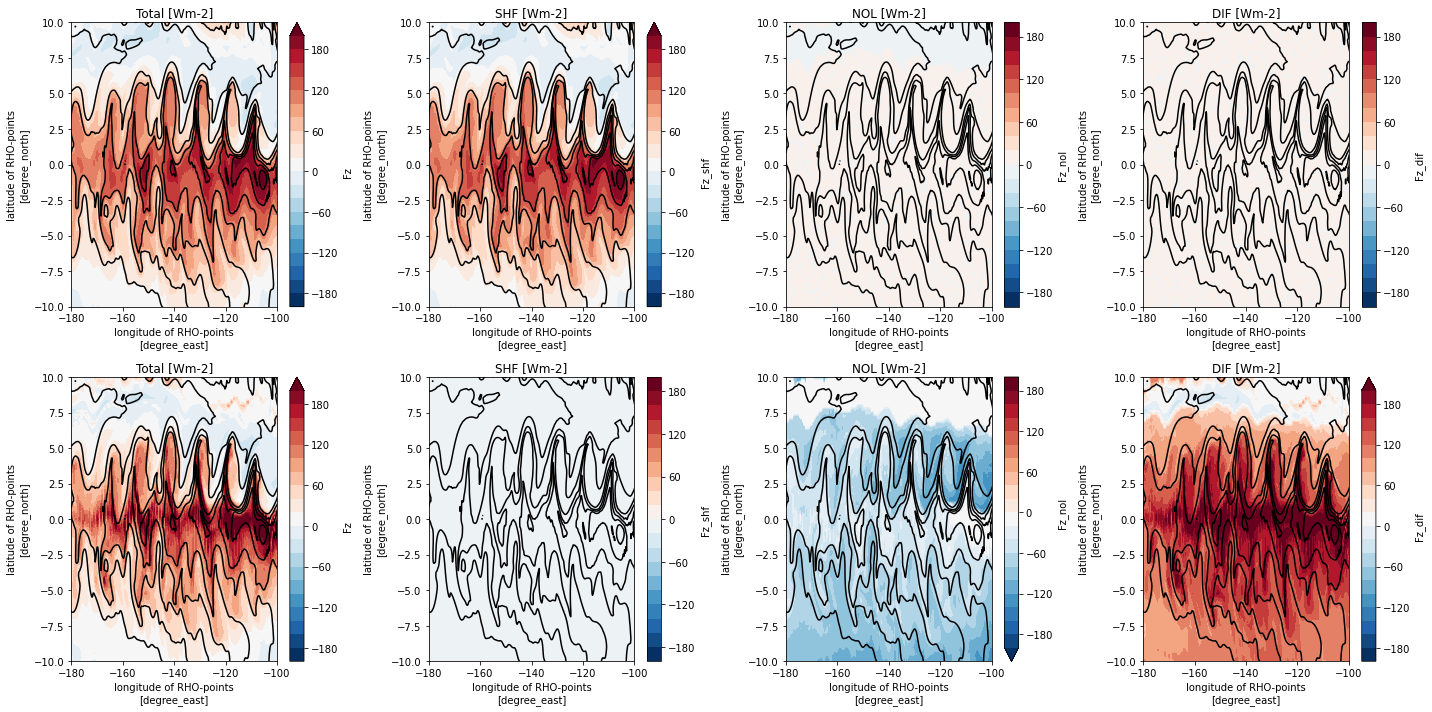

In [13]:
# Components of diffusion:
time = 10
SST = favg.temp.isel(ocean_time=time).isel(s_rho=-1)

plt.figure(figsize=(20,10))
xlims = [-180.,-100.]
ylims = [-10.,10.]
cbar = np.arange(-200.,220.,20.)

plt.subplot(2,4,1)
fdia.Fz.isel(ocean_time=time).isel(s_w=-1).plot.contourf(x='lon_rho',y='lat_rho',levels=cbar)
SST.plot.contour(x='lon_rho',y='lat_rho',levels=np.arange(0.,34.,1.),colors='k')
plt.xlim(xlims)
plt.ylim(ylims)
plt.title('Total [Wm-2]')

plt.subplot(2,4,2)
fdia.Fz_shf.isel(ocean_time=time).isel(s_w=-1).plot.contourf(x='lon_rho',y='lat_rho',levels=cbar)
SST.plot.contour(x='lon_rho',y='lat_rho',levels=np.arange(0.,34.,1.),colors='k')
plt.xlim(xlims)
plt.ylim(ylims)
plt.title('SHF [Wm-2]')

plt.subplot(2,4,3)
fdia.Fz_nol.isel(ocean_time=time).isel(s_w=-1).plot.contourf(x='lon_rho',y='lat_rho',levels=cbar)
SST.plot.contour(x='lon_rho',y='lat_rho',levels=np.arange(0.,34.,1.),colors='k')
plt.xlim(xlims)
plt.ylim(ylims)
plt.title('NOL [Wm-2]')

plt.subplot(2,4,4)
fdia.Fz_dif.isel(ocean_time=time).isel(s_w=-1).plot.contourf(x='lon_rho',y='lat_rho',levels=cbar)
SST.plot.contour(x='lon_rho',y='lat_rho',levels=np.arange(0.,34.,1.),colors='k')
plt.xlim(xlims)
plt.ylim(ylims)
plt.title('DIF [Wm-2]')

plt.subplot(2,4,5)
fdia.Fz.isel(ocean_time=time).isel(s_w=-2).plot.contourf(x='lon_rho',y='lat_rho',levels=cbar)
SST.plot.contour(x='lon_rho',y='lat_rho',levels=np.arange(0.,34.,1.),colors='k')
plt.xlim(xlims)
plt.ylim(ylims)
plt.title('Total [Wm-2]')

plt.subplot(2,4,6)
fdia.Fz_shf.isel(ocean_time=time).isel(s_w=-2).plot.contourf(x='lon_rho',y='lat_rho',levels=cbar)
SST.plot.contour(x='lon_rho',y='lat_rho',levels=np.arange(0.,34.,1.),colors='k')
plt.xlim(xlims)
plt.ylim(ylims)
plt.title('SHF [Wm-2]')

plt.subplot(2,4,7)
fdia.Fz_nol.isel(ocean_time=time).isel(s_w=-2).plot.contourf(x='lon_rho',y='lat_rho',levels=cbar)
SST.plot.contour(x='lon_rho',y='lat_rho',levels=np.arange(0.,34.,1.),colors='k')
plt.xlim(xlims)
plt.ylim(ylims)
plt.title('NOL [Wm-2]')

plt.subplot(2,4,8)
fdia.Fz_dif.isel(ocean_time=time).isel(s_w=-2).plot.contourf(x='lon_rho',y='lat_rho',levels=cbar)
SST.plot.contour(x='lon_rho',y='lat_rho',levels=np.arange(0.,34.,1.),colors='k')
plt.xlim(xlims)
plt.ylim(ylims)
plt.title('DIF [Wm-2]')

plt.tight_layout()

(-20.0, 20.0)

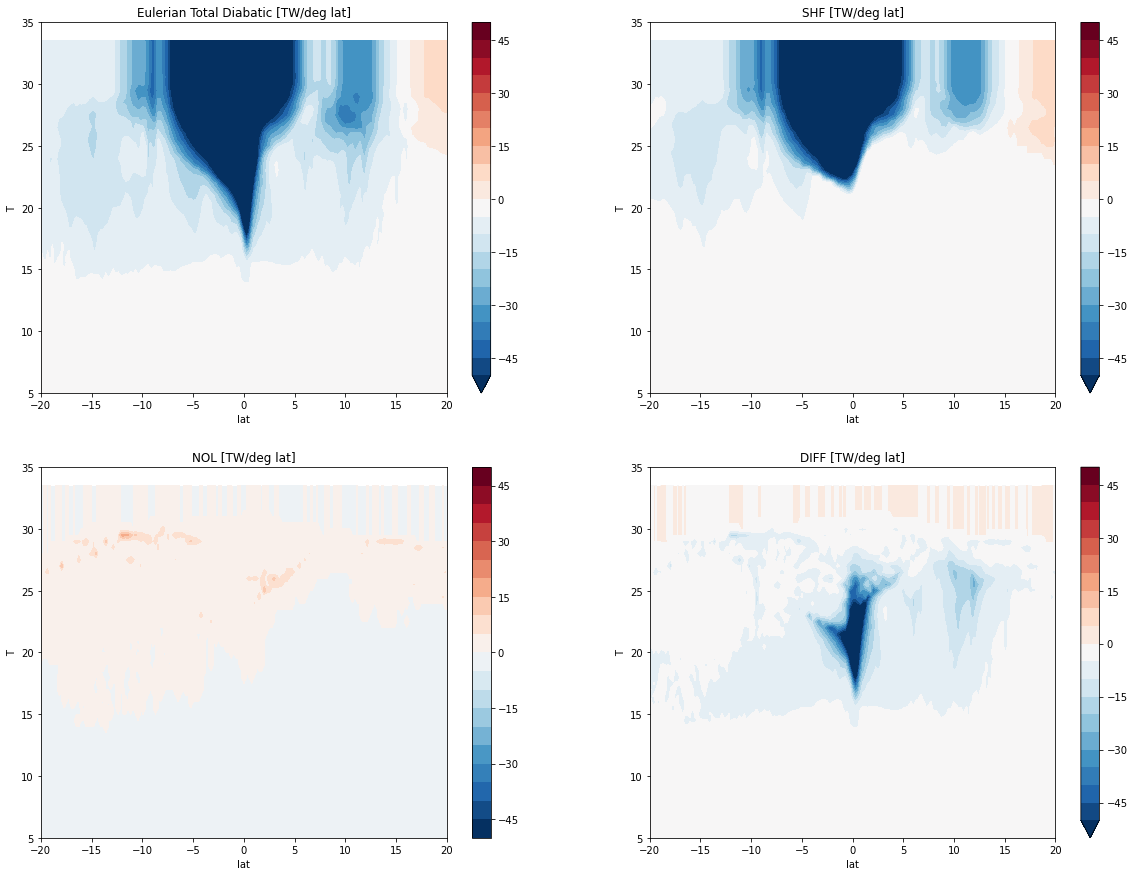

In [18]:
# Temperature coordinates plotting:
plt.figure(figsize=(20,15))

HfDia_mean = -fdia_mean.HfDia.mean('ocean_time')*favg.pn.mean('xi_rho')*110000./1.e12
HfDia_shf_mean = -fdia_mean.HfDia_shf.mean('ocean_time')*favg.pn.mean('xi_rho')*110000./1.e12
HfDia_nol_mean = -fdia_mean.HfDia_nol.mean('ocean_time')*favg.pn.mean('xi_rho')*110000./1.e12
HfDia_dif_mean = -fdia_mean.HfDia_dif.mean('ocean_time')*favg.pn.mean('xi_rho')*110000./1.e12

xlims = [-20.,20.]
ylimsT = [5.,35.]
cbar_levels_Di = np.arange(-50.,55.,5.)

plt.subplot(2,2,1)
HfDia_mean.plot.contourf(levels=cbar_levels_Di,cmap='RdBu_r',x='lat')
plt.title('Eulerian Total Diabatic [TW/deg lat]')
plt.ylim(ylimsT)
plt.xlim(xlims)

plt.subplot(2,2,2)
HfDia_shf_mean.plot.contourf(levels=cbar_levels_Di,cmap='RdBu_r',x='lat')
plt.title('SHF [TW/deg lat]')
plt.ylim(ylimsT)
plt.xlim(xlims)

plt.subplot(2,2,3)
HfDia_nol_mean.plot.contourf(levels=cbar_levels_Di,cmap='RdBu_r',x='lat')
plt.title('NOL [TW/deg lat]')
plt.ylim(ylimsT)
plt.xlim(xlims)

plt.subplot(2,2,4)
HfDia_dif_mean.plot.contourf(levels=cbar_levels_Di,cmap='RdBu_r',x='lat')
plt.title('DIFF [TW/deg lat]')
plt.ylim(ylimsT)
plt.xlim(xlims)

## Meridional overturning circulation plots:

In [19]:
# Calculate total, eddy and mean components of MOC, heat function and diabatic contributions

# Streamfunction:
PsiLag  = (favg.PsiLag-favg.PsiLag.isel(T=-1)).mean('ocean_time')/1.e6
PsiLag_mean = (favg_mean.PsiLag-favg_mean.PsiLag.isel(T=-1)).mean('ocean_time')/1.e6
PsiLag_eddy = PsiLag - PsiLag_mean

# Heat function:
HfLag = rho0*Cp*dT*PsiLag.cumsum('T')*1.e6/1.e15
HfLag = HfLag-HfLag.isel(T=-1)
HfLag_mean = rho0*Cp*dT*PsiLag_mean.cumsum('T')*1.e6/1.e15
HfLag_mean = HfLag_mean-HfLag_mean.isel(T=-1)
HfLag_eddy = HfLag - HfLag_mean

# Total Diabatic:
# HfDia = -fdia.HfDia.mean('ocean_time')*favg.pn.mean('xi_rho')*110000./1.e12
# HfDia_mean = -fdia_mean.HfDia.mean('ocean_time')*favg.pn.mean('xi_rho')*110000./1.e12
# HfDia_eddy = HfDia - HfDia_mean

# Air-sea heat flux diabatic:
HfDia_shf = -fdia.HfDia_shf.mean('ocean_time')*favg.pn.mean('xi_rho')*110000./1.e12
HfDia_shf_mean = -fdia_mean.HfDia_shf.mean('ocean_time')*favg.pn.mean('xi_rho')*110000./1.e12
HfDia_shf_eddy = HfDia_shf - HfDia_shf_mean

# Mixing diabatic:
HfDia_dif = -fdia.HfDia_dif.mean('ocean_time')*favg.pn.mean('xi_rho')*110000./1.e12
HfDia_dif_mean = -fdia_mean.HfDia_dif.mean('ocean_time')*favg.pn.mean('xi_rho')*110000./1.e12
HfDia_dif_eddy = HfDia_dif - HfDia_dif_mean

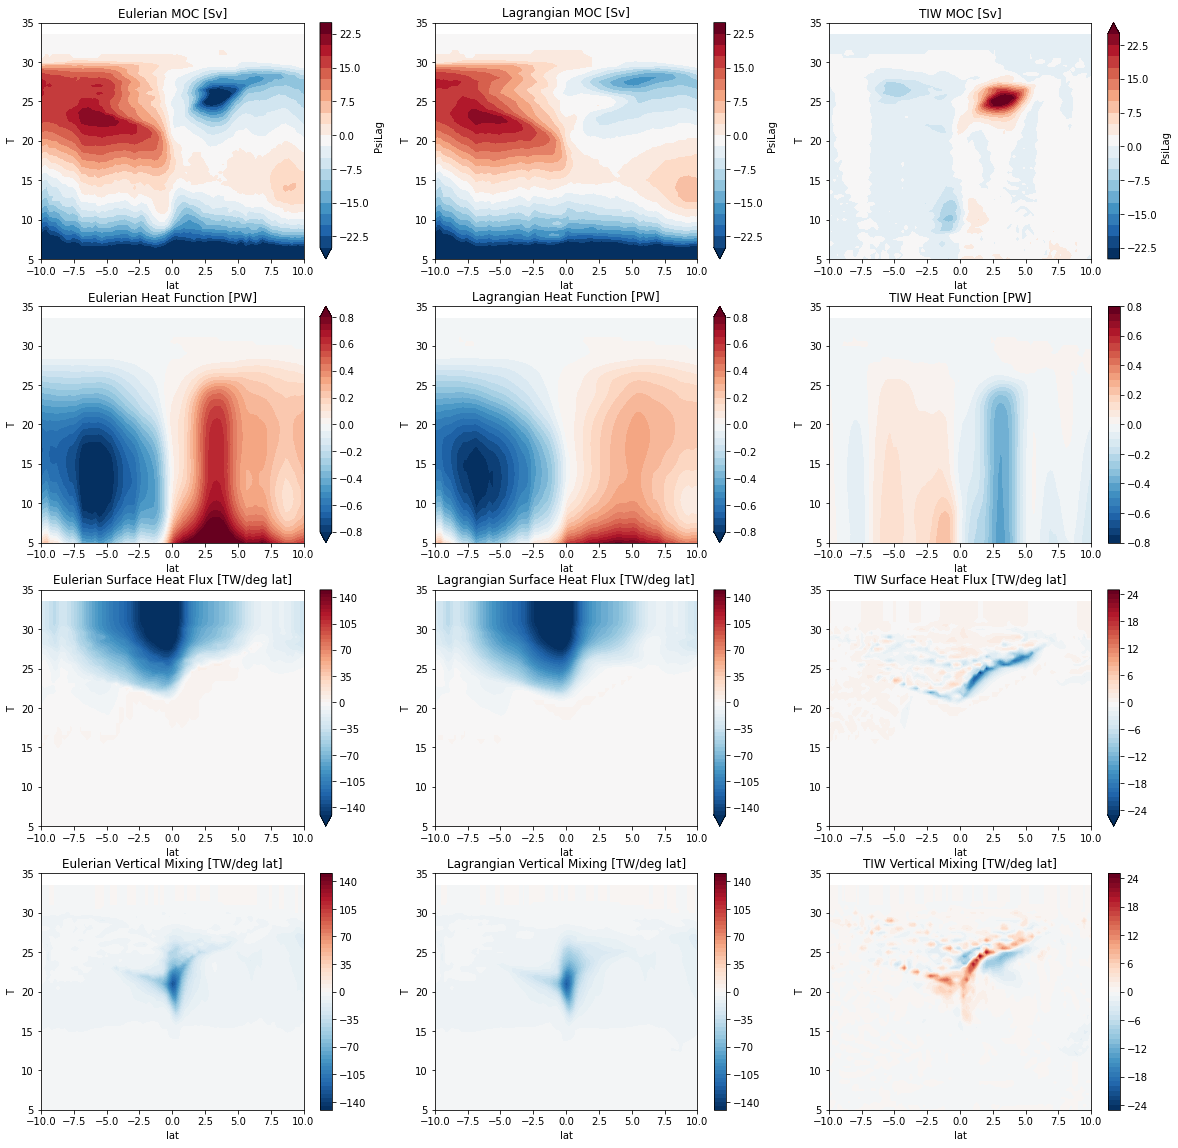

In [22]:
# Temperature coordinates plotting:
plt.figure(figsize=(20,20))

xlims = [-10.,10.]
ylimsT = [5.,35.]
cbar_levels = np.arange(-25.,27.5,2.5)
cbar_levels_Hf = np.arange(-0.8,0.85,0.05)
cbar_levels_Di = np.arange(-150.,155.,5.)

cbar_levels_eddy = np.arange(-25.,27.5,2.5)
cbar_levels_Hf_eddy = np.arange(-0.8,0.85,0.05)
cbar_levels_Di_eddy = np.arange(-25.,26.,1.)

plt.subplot(4,3,1)
PsiLag_mean.plot.contourf(levels=cbar_levels,cmap='RdBu_r',x='lat')
plt.title('Eulerian MOC [Sv]')
plt.ylim(ylimsT)
plt.xlim(xlims)

plt.subplot(4,3,2)
PsiLag.plot.contourf(levels=cbar_levels,cmap='RdBu_r',x='lat')
plt.title('Lagrangian MOC [Sv]')
plt.ylim(ylimsT)
plt.xlim(xlims)

plt.subplot(4,3,3)
PsiLag_eddy.plot.contourf(levels=cbar_levels_eddy,cmap='RdBu_r',x='lat')
plt.title('TIW MOC [Sv]')
plt.ylim(ylimsT)
plt.xlim(xlims)

plt.subplot(4,3,4)
HfLag_mean.plot.contourf(levels=cbar_levels_Hf,cmap='RdBu_r',x='lat')
plt.title('Eulerian Heat Function [PW]')
plt.ylim(ylimsT)
plt.xlim(xlims)

plt.subplot(4,3,5)
HfLag.plot.contourf(levels=cbar_levels_Hf,cmap='RdBu_r',x='lat')
plt.title('Lagrangian Heat Function [PW]')
plt.ylim(ylimsT)
plt.xlim(xlims)

plt.subplot(4,3,6)
HfLag_eddy.plot.contourf(levels=cbar_levels_Hf_eddy,cmap='RdBu_r',x='lat')
plt.title('TIW Heat Function [PW]')
plt.ylim(ylimsT)
plt.xlim(xlims)

# plt.subplot(5,3,7)
#HfDia_mean.plot.contourf(levels=cbar_levels_Di,cmap='RdBu_r',x='lat')
#plt.title('Eulerian Total Diabatic [TW/deg lat]')
#plt.ylim(ylimsT)
#plt.xlim(xlims)

#plt.subplot(5,3,8)
#HfDia.plot.contourf(levels=cbar_levels_Di,cmap='RdBu_r',x='lat')
#plt.title('Lagrangian Total Diabatic [TW/deg lat]')
#plt.ylim(ylimsT)
#plt.xlim(xlims)

#plt.subplot(5,3,9)
#HfDia_eddy.plot.contourf(levels=cbar_levels_Di_eddy,cmap='RdBu_r',x='lat')
#plt.title('TIW Total Diabatic [TW/deg lat]')
#plt.ylim(ylimsT)
#plt.xlim(xlims)

plt.subplot(4,3,7)
HfDia_shf_mean.plot.contourf(levels=cbar_levels_Di,cmap='RdBu_r',x='lat')
plt.title('Eulerian Surface Heat Flux [TW/deg lat]')
plt.ylim(ylimsT)
plt.xlim(xlims)

plt.subplot(4,3,8)
HfDia_shf.plot.contourf(levels=cbar_levels_Di,cmap='RdBu_r',x='lat')
plt.title('Lagrangian Surface Heat Flux [TW/deg lat]')
plt.ylim(ylimsT)
plt.xlim(xlims)

plt.subplot(4,3,9)
HfDia_shf_eddy.plot.contourf(levels=cbar_levels_Di_eddy,cmap='RdBu_r',x='lat')
plt.title('TIW Surface Heat Flux [TW/deg lat]')
plt.ylim(ylimsT)
plt.xlim(xlims)

plt.subplot(4,3,10)
HfDia_dif_mean.plot.contourf(levels=cbar_levels_Di,cmap='RdBu_r',x='lat')
plt.title('Eulerian Vertical Mixing [TW/deg lat]')
plt.ylim(ylimsT)
plt.xlim(xlims)

plt.subplot(4,3,11)
HfDia_dif.plot.contourf(levels=cbar_levels_Di,cmap='RdBu_r',x='lat')
plt.title('Lagrangian Vertical Mixing [TW/deg lat]')
plt.ylim(ylimsT)
plt.xlim(xlims)

plt.subplot(4,3,12)
HfDia_dif_eddy.plot.contourf(levels=cbar_levels_Di_eddy,cmap='RdBu_r',x='lat')
plt.title('TIW Vertical Mixing [TW/deg lat]')
plt.ylim(ylimsT)
plt.xlim(xlims)

plt.savefig('MOCs_and_Diabatic_60days_ROMS.png',dpi=150)

# Mixing heat function testing:

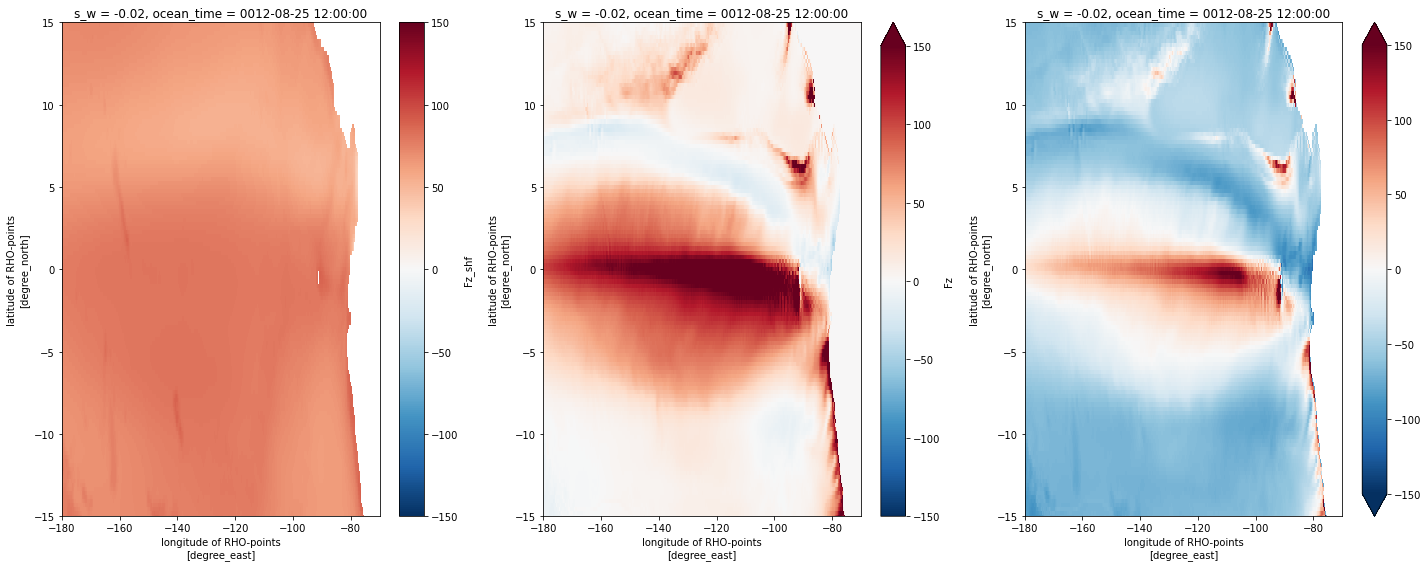

In [12]:
fig = plt.figure(figsize=(20,15))
xlims = [-180.,-70.]
ylims = [-15.,15.]
vmin = -150.
vmax = 150.

#plt.subplot(2,3,1)
#fdia_mean.Fz_shf.isel(s_w=-1).plot(x='lon_rho',y='lat_rho',vmin=vmin,vmax=vmax,cmap='RdBu_r')
#plt.xlim(xlims)
#plt.ylim(ylims)

#plt.subplot(2,3,2)
#fdia_mean.Fz.isel(s_w=-1).plot(x='lon_rho',y='lat_rho',vmin=vmin,vmax=vmax,cmap='RdBu_r')
#plt.xlim(xlims)
#plt.ylim(ylims)

#plt.subplot(2,3,3)
#favg_mean.shflux.plot()
#plt.xlim(xlims)
#plt.ylim(ylims)

plt.subplot(2,3,1)
fdia_mean.Fz_shf.isel(s_w=-2).plot(x='lon_rho',y='lat_rho',vmin=vmin,vmax=vmax,cmap='RdBu_r')
plt.xlim(xlims)
plt.ylim(ylims)

plt.subplot(2,3,2)
fdia_mean.Fz.isel(s_w=-2).plot(x='lon_rho',y='lat_rho',vmin=vmin,vmax=vmax,cmap='RdBu_r')
plt.xlim(xlims)
plt.ylim(ylims)

plt.subplot(2,3,3)
(fdia_mean.Fz.isel(s_w=-2)-fdia_mean.Fz_shf.isel(s_w=-2)).plot(x='lon_rho',y='lat_rho',vmin=vmin,vmax=vmax,cmap='RdBu_r')
plt.xlim(xlims)
plt.ylim(ylims)

plt.tight_layout()

## Depth space overturning:

In [56]:
### NOTE: BELOW HERE IS CURRENTLY NOT WORKING.

#Function to plot Lagrangian remapped to z-grid:
def CalcPsiLagZ(favg):
    z_v = grid.interp(favg.z_rho,axis='eta').rename({'xi_rho':'xi_v'}).rename('z_v')
    temp_v = grid.interp(favg.temp,axis='eta').rename({'xi_rho':'xi_v'}).rename('temp_v')
    
    z_v_temp = grid.transform(z_v.where(z_v!=0), 's', tvec, target_data=temp_v).rename({'temp_v':'T'}).mean('xi_v')
    z_v_temp = z_v_temp.where(np.logical_not(np.logical_and(favg.T_e>10.,np.isnan(z_v_temp))),0.).where(np.logical_not(np.logical_and(favg.T_e<10.,np.isnan(z_v_temp))),-5000.)
    favg['PsiLagZ'] = grid.transform(favg.PsiLag, 'T', zvec, target_data=z_v_temp).rename({'z_v':'z_e'})
    
    return(favg)

In [57]:
favg = CalcPsiLagZ(favg)
favg_mean = CalcPsiLagZ(favg_mean)

In [ ]:
# Eulerian overturning:
# Streamfunction:
PsiLag  = (favg.PsiLag-favg.PsiLag.isel(T=-1)).mean('ocean_time')/1.e6
PsiLag_mean = (favg_mean.PsiLag-favg_mean.PsiLag.isel(T=-1)).mean('ocean_time')/1.e6
PsiLag_eddy = PsiLag - PsiLag_mean

In [42]:
# Time-mean z_v_temp and PsiLag on z remapping:
z_v_temp = favgpl.z_v_temp.mean('ocean_time')
z_v_temp = z_v_temp.where(np.logical_not(np.logical_and(favg.T>10.,np.isnan(z_v_temp))),0.).where(np.logical_not(np.logical_and(favg.T<10.,np.isnan(z_v_temp))),-5000.)

favgpl['PsiLagZ'] = grid.transform(favgpl.PsiLag.mean('ocean_time'), 'T', zvec, target_data=z_v_temp).rename({'z_v_temp':'z_e'})
favg_mean['PsiLagZ'] = grid.transform(favg_mean.PsiLag.mean('ocean_time'), 'T', zvec, target_data=z_v_temp).rename({'z_v_temp':'z_e'})

PsiEul  = (favgpl.PsiEul-favgpl.PsiEul.isel(z=-1)).mean('ocean_time')/1.e6
PsiLagZ = (favgpl.PsiLagZ-favgpl.PsiLag.isel(T=-1).mean('ocean_time'))/1.e6
PsiLagZ_mean = (favg_mean.PsiLagZ-favg_mean.PsiLag.isel(T=-1).mean('ocean_time'))/1.e6
PsiLagZ_eddy = PsiLagZ - PsiLagZ_mean

(-10.0, 10.0)

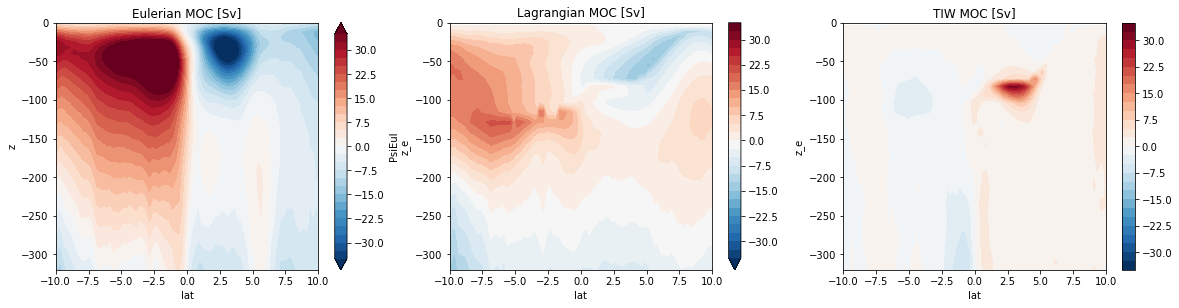

In [44]:
# Depth coordinates plotting:
plt.figure(figsize=(20,10))

xlims = [-10.,10.]
ylimsZ = [-320.,0.]
cbar_levels = np.arange(-35.,37.5,2.5)

plt.subplot(2,3,1)
PsiEul.plot.contourf(levels=cbar_levels,cmap='RdBu_r',x='lat')
plt.title('Eulerian MOC [Sv]')
plt.ylim(ylimsZ)
plt.xlim(xlims)

plt.subplot(2,3,2)
PsiLagZ.plot.contourf(levels=cbar_levels,cmap='RdBu_r',x='lat')
plt.title('Lagrangian MOC [Sv]')
plt.ylim(ylimsZ)
plt.xlim(xlims)

plt.subplot(2,3,3)
PsiLagZ_eddy.plot.contourf(levels=cbar_levels,cmap='RdBu_r',x='lat')
plt.title('TIW MOC [Sv]')
plt.ylim(ylimsZ)
plt.xlim(xlims)

## Some checking plots:

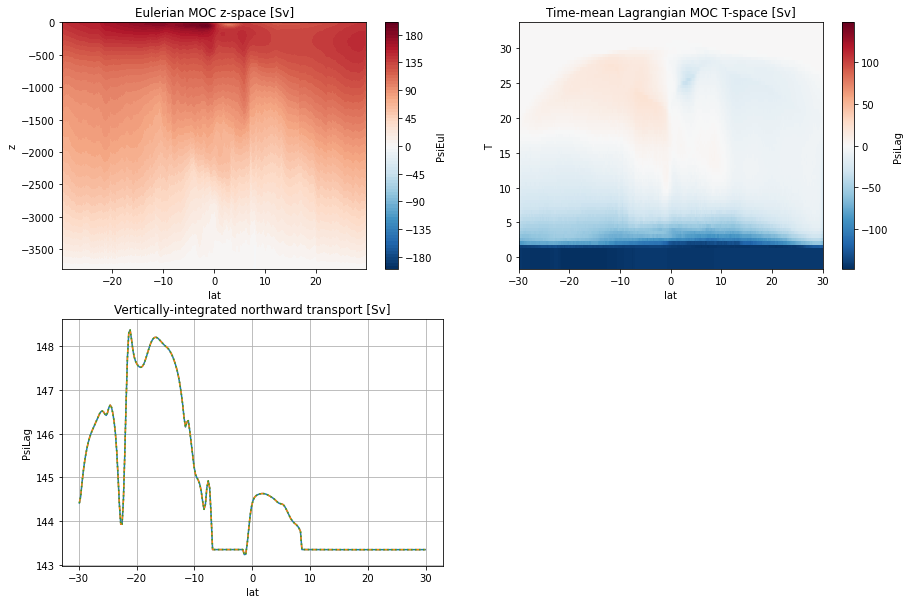

In [42]:
# Check net northward transport using Hvom vertical sum and vbar and plot:
vnet = favg_mean.Hvom.sum('s_rho').sum('xi_v').isel(ocean_time=0)/1.e6
#vnet_bar = favg_mean.vbar*(favg_mean.zeta+favg_mean.h)*favg_mean.

plt.figure(figsize=(15,10))
plt.subplot(2,2,1)
(favg_mean.PsiEul/1.e6).isel(ocean_time=0).plot.contourf(levels=np.arange(-200.,205.,5.),cmap='RdBu_r',x='lat')
plt.title('Eulerian MOC z-space [Sv]')

plt.subplot(2,2,2)
((favg_mean.PsiLag-favg_mean.PsiLag.isel(T=-1))/1.e6).isel(ocean_time=0).plot(x='lat')
plt.title('Time-mean Lagrangian MOC T-space [Sv]')

plt.subplot(2,2,3)
(favg_mean.PsiEul.isel(ocean_time=0).isel(z=-1)/1.e6).plot(x='lat',label='From z MOC')
vnet.plot(x='lat',label='From Hvom vertical sum',linestyle='dashed')
(favg_mean.PsiLag.isel(ocean_time=0).isel(T=-1)/1.e6).plot(x='lat',label='From T MOC',linestyle='dotted')
plt.title('Vertically-integrated northward transport [Sv]')
plt.grid()

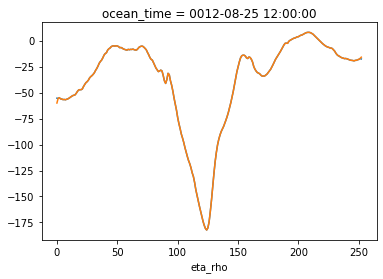

In [43]:
HfDia_mean.isel(T=-1).plot()
(-(favg_mean.shflux.isel(ocean_time=0)/favg_mean.pn/favg_mean.pm).sum('xi_rho')*favg.pn.mean('xi_rho')*110000./1.e12).plot()
#favg_mean.shflux.isel(ocean_time=0).plot()

In [8]:
# Calculate zonally-integrated Eulerian and Lagrangian MOCs (time mean, using xhistogram):
# This is done using xhistogram for xarray, see https://xhistogram.readthedocs.io/en/latest/tutorial.html
# Also see Jan's true zonal mean method in the COSIMA recipes https://github.com/COSIMA/cosima-recipes/blob/master/DocumentedExamples/True_Zonal_Mean.ipynb

# Using pre-calculated z_v:
# z_v = favg_mean.z_v.fillna(0.)
# Using on-the-fly xgcm interp:
z_v = grid.interp(favg_mean.z_rho,axis='eta').rename({'xi_rho':'xi_v'}).rename('z_v')

PsiE = histogram(z_v,bins=zvec,weights=favg_mean.Hvom.fillna(0.),dim=['xi_v','s_rho'])
PsiE = PsiE.cumsum('z_v_bin').rename({'z_v_bin':'z'})
PsiE['z'] = zvec[1:]
PsiE.coords['lat'] = favg_mean.lat_v.mean('xi_v')
favg_mean['PsiEul'] = PsiE

temp_v = grid.interp(favg_mean.temp,axis='eta').rename({'xi_rho':'xi_v'}).rename('temp_v')
PsiL = histogram(temp_v.fillna(0.),bins=tvec,weights=favg_mean.Hvom.fillna(0.),dim=['xi_v','s_rho'])
PsiL = PsiL.cumsum('temp_v_bin').rename({'temp_v_bin':'T'})
PsiL['T'] = tvec[1:]
PsiL.coords['lat'] = favg_mean.lat_v.mean('xi_v')
favg_mean['PsiLag'] = PsiL

# Mixing and surface forcing components:
dz_mean = favg_mean.z_w.diff('s_w').rename({'s_w':'s_rho'}).assign_coords(s_rho=favg_mean.s_rho)
Fz_conv_mean = Cp*rho0*fdia_mean.temp_vdiff*dz/favg_mean.pm/favg_mean.pn
HfDia_mean = histogram(favg_mean.temp.fillna(0.),bins=tvec,weights=Fz_conv_mean.fillna(0.),dim=['xi_rho','s_rho'])
HfDia_mean = HfDia_mean.cumsum('temp_bin').rename({'temp_bin':'T'})
HfDia_mean['T'] = tvec[1:]
HfDia_mean.coords['lat'] = fdia_mean.lat_rho.mean('xi_rho')
fdia_mean['HfDia'] = HfDia_mean

# Do the calculation:
favg_mean.PsiEul.load();
favg_mean.PsiLag.load();
fdia_mean.HfDia.load();

In [27]:
# Time-varying calculations:
z_v = grid.interp(favg.z_rho,axis='eta').rename({'xi_rho':'xi_v'}).rename('z_v')
PsiE = histogram(z_v,bins=zvec,weights=favg.Hvom.fillna(0.),dim=['xi_v','s_rho'])

PsiE = PsiE.cumsum('z_v_bin').rename({'z_v_bin':'z'})
PsiE['z'] = zvec[1:]
PsiE.coords['lat'] = favg.lat_v.mean('xi_v')
favg['PsiEul'] = PsiE

temp_v = grid.interp(favg.temp,axis='eta').rename({'xi_rho':'xi_v'}).rename('temp_v')
PsiL = histogram(temp_v.fillna(0.),bins=tvec,weights=favg.Hvom.fillna(0.),dim=['xi_v','s_rho'])
PsiL = PsiL.cumsum('temp_v_bin').rename({'temp_v_bin':'T'})
PsiL['T'] = tvec[1:]
PsiL.coords['lat'] = favg.lat_v.mean('xi_v')
favg['PsiLag'] = PsiL

# Remap using zonal and temporal mean depth of temperature surfaces
favg['z_v_temp'] = grid.transform(z_v.where(z_v!=0), 's', tvec, target_data=temp_v).rename({'temp_v':'T'}).mean('xi_v')

In [30]:
# Total diabatic:
dz = favg.z_w.diff('s_w').rename({'s_w':'s_rho'}).assign_coords(s_rho=favg.s_rho)
Fz_conv = Cp*rho0*fdia.temp_vdiff*dz/favg.pm/favg.pn
HfDia = histogram(favg.temp.fillna(0.),bins=tvec,weights=Fz_conv.fillna(0.),dim=['xi_rho','s_rho'])
HfDia = HfDia.cumsum('temp_bin').rename({'temp_bin':'T'})
HfDia['T'] = tvec[1:]
HfDia.coords['lat'] = fdia.lat_rho.mean('xi_rho')
fdia['HfDia'] = HfDia

In [32]:
# Select a slice for testing:
favgpl = favg.isel(ocean_time=slice(0,60))
fdiapl = fdia.isel(ocean_time=slice(0,60))

In [34]:
# Load variables:
favgpl.PsiEul.load();
favgpl.PsiLag.load();
favgpl.z_v_temp.load();
fdiapl.HfDia.load();

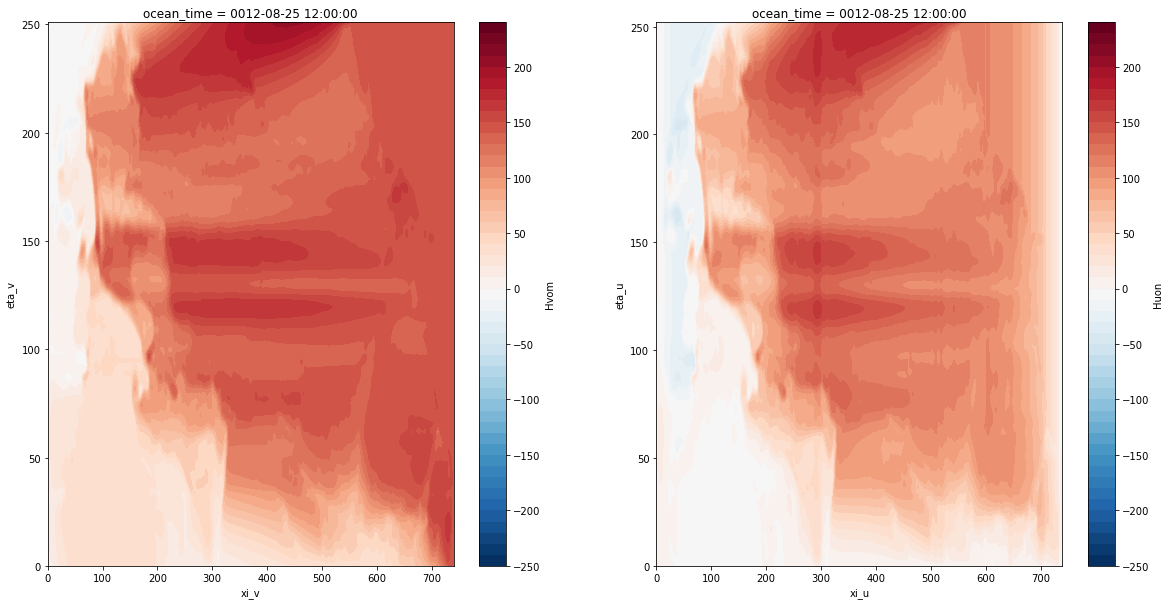

In [ ]:
# Barotropic Streamfunction:

plt.figure(figsize=(20,10))
plt.subplot(1,2,1)
(favg_mean.Hvom.sum('s_rho').cumsum('xi_v')/1.e6).isel(ocean_time=0).plot.contourf(levels=np.arange(-250.,250.,10.),cmap='RdBu_r')
plt.subplot(1,2,2)
(-favg_mean.Huon.sum('s_rho').cumsum('eta_u')/1.e6).isel(ocean_time=0).plot.contourf(levels=np.arange(-250.,250.,10.),cmap='RdBu_r')

In [17]:
# Add/calculate vertical coordinate (not needed if pre-calculated using ROMS matlab software):
if favg.Vtransform == 1:
    Zo_rho = favg.hc * (favg.s_rho - favg.Cs_r) + favg.Cs_r * favg.h
    z_rho = Zo_rho + favg.zeta * (1 + Zo_rho / favg.h)
elif favg.Vtransform == 2:
    Zo_rho = (favg.hc * favg.s_rho + favg.Cs_r * favg.h) / (favg.hc + favg.h)
    z_rho = favg.zeta + (favg.zeta + favg.h) * Zo_rho

favg.coords["z_rho"] = z_rho.transpose()  # needing transpose seems to be an xarray bug
fdia.coords["z_rho"] = z_rho.transpose()  # needing transpose seems to be an xarray bug
favg_mean.coords["z_rho"] = z_rho.transpose().mean('ocean_time')  # needing transpose seems to be an xarray bug
favg_mean.temp

<xarray.DataArray 'temp' (ocean_time: 1, s_rho: 50, eta_rho: 253, xi_rho: 741)>
dask.array<xarray-temp, shape=(1, 50, 253, 741), dtype=float32, chunksize=(1, 50, 253, 741), chunktype=numpy.ndarray>
Coordinates:
    Vtransform  int32 1
    hc          float64 75.0
  * s_rho       (s_rho) float64 -0.99 -0.97 -0.95 -0.93 ... -0.05 -0.03 -0.01
    Cs_r        (s_rho) float64 dask.array<chunksize=(50,), meta=np.ndarray>
    h           (eta_rho, xi_rho) float64 dask.array<chunksize=(253, 741), meta=np.ndarray>
    lon_rho     (eta_rho, xi_rho) float64 dask.array<chunksize=(253, 741), meta=np.ndarray>
    lat_rho     (eta_rho, xi_rho) float64 dask.array<chunksize=(253, 741), meta=np.ndarray>
  * ocean_time  (ocean_time) object 0012-08-25 12:00:00
    z_rho       (eta_rho, xi_rho, s_rho) float64 dask.array<chunksize=(253, 741, 50), meta=np.ndarray>
Dimensions without coordinates: eta_rho, xi_rho
Attributes:
    long_name:     time-averaged potential temperature
    units:         Celsius
    time:          ocean_time
    grid:          grid
    location:      face
    field:         temperature, scalar, series
    cell_methods:  ocean_time: mean

In [7]:
### Calculate (differed) 3D total vertical diffusive heat flux and air-sea component:
# total vertical heat flux (Wm-2) on s_w:
dz = favg.z_w.diff('s_w').rename({'s_w':'s_rho'}).assign_coords(s_rho=favg.s_rho)
Fz = (Cp*rho0*fdia.temp_vdiff*dz).cumsum('s_rho')
Fz = xr.concat([0*Fz.isel(s_rho=0),Fz],dim='s_rho').rename({'s_rho':'s_w'}).assign_coords(s_w=favg.s_w)
fdia['Fz'] = Fz

# Calculate component due to surface fluxes/shortwave penetration (follow code in lmd_skpp.F, lmd_swfrac.F):
#lmd_Jwt = 1, lmd_mu1 = 0.35, lmd_mu2 = 23.0, lmd_r1 = 0.58
fac1 = -1.0/0.35
fac2 = -1.0/23.0
fac3 = 0.58
d = favg.z_w.where(favg.s_w==0.,other=0.)-favg.z_w # Depth on z_w
Fz_shf = favg.swrad*(np.exp(d*fac1)*fac3+np.exp(d*fac2)*(1.0-fac3)) # Shortwave flux

# Add surface flux component:
surf = xr.zeros_like(favg.s_w)
surf[-1] = 1.
Fz_shf += (favg.shflux-favg.swrad)*surf # Total surface flux (3D)
fdia['Fz_shf'] = Fz_shf

# Note: the use of where above, and surf, was to keep the delayed computation aspect of the calculation.

# Diffusive component by residual:
#Fz_diff = Fz - Fz_shf
#Fz_diff_max = Fz_diff.max('s_w')

Text(0.5, 1.0, 'Net surface heat flux (Wm-2)')

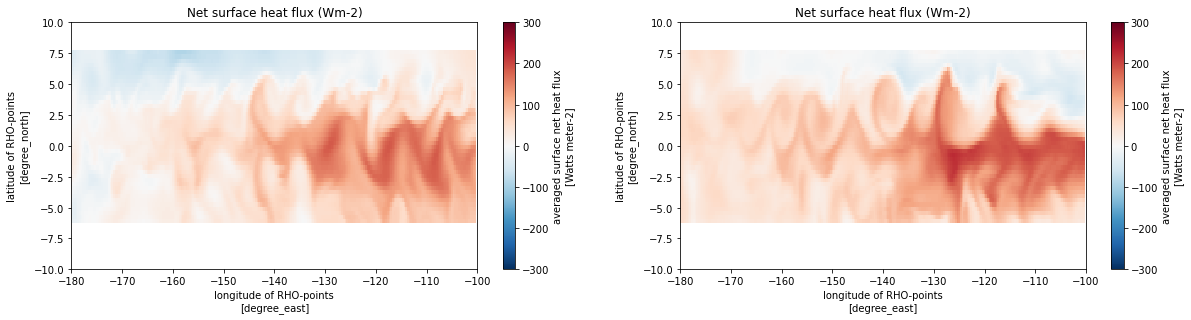

In [24]:
# CROCO air-sea heat flux:
plt.figure(figsize=(20,10))
xlims = [-180.,-100.]
ylims = [-10.,10.]

plt.subplot(2,2,1)
CROCOavg.shflux.isel(time=-1).plot(vmin=-300.,vmax=300.,cmap='RdBu_r',x='lon_rho',y='lat_rho')
plt.xlim(xlims)
plt.ylim(ylims)
plt.title('Net surface heat flux (Wm-2)')

plt.subplot(2,2,2)
CROCOavg.shflux.isel(time=-100).plot(vmin=-300.,vmax=300.,cmap='RdBu_r',x='lon_rho',y='lat_rho')
plt.xlim(xlims)
plt.ylim(ylims)
plt.title('Net surface heat flux (Wm-2)')